<a href="https://colab.research.google.com/github/makhammadsoliyev/CreditScoring/blob/main/scoring_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12, 6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings

warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [9]:
# All necessary libraries
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.saving import save_model

In [11]:
train = pd.read_csv('/content/train.csv', dtype={'Column26': str})
train.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_Months
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843,3,...,Good,809.98,26.823,No,49.575,118.280,High_spent_Small_value_payments,312.494,Good,265.000
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843,3,...,Good,809.98,31.945,No,49.575,118.280,Low_spent_Large_value_payments,284.629,Good,265.000
2,0x1604,CUS_0xd40,March,Aaron Maashoh,5,821-00-0265,Scientist,19114.12,1824.843,3,...,Good,809.98,28.609,No,49.575,118.280,Low_spent_Medium_value_payments,331.210,Good,267.000
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843,3,...,Good,809.98,31.378,No,49.575,118.280,Low_spent_Small_value_payments,223.451,Good,268.000
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843,3,...,Good,809.98,24.797,No,49.575,118.280,High_spent_Medium_value_payments,341.489,Good,269.000


In [12]:
train.shape

(38092, 28)

In [13]:
df = train
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38092 entries, 0 to 38091
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         38092 non-null  object 
 1   Customer_ID                38092 non-null  object 
 2   Month                      38092 non-null  object 
 3   Name                       38092 non-null  object 
 4   Age                        38092 non-null  int64  
 5   SSN                        38092 non-null  object 
 6   Occupation                 38092 non-null  object 
 7   Annual_Income              38092 non-null  object 
 8   Monthly_Inhand_Salary      38092 non-null  float64
 9   Num_Bank_Accounts          38092 non-null  int64  
 10  Num_Credit_Card            38092 non-null  int64  
 11  Interest_Rate              38092 non-null  float64
 12  Num_of_Loan                38092 non-null  int64  
 13  Type_of_Loan               38092 non-null  obj

In [14]:
# Oxiridagi _ ni olib tashlash uchun
def remove_trailing_dash(value):
    if isinstance(value, str) and value.endswith('_'):
        return value[:-1]  # Oxirgi belgini olib tashlang (chiziq)
    else:
        return value


df['Annual_Income'] = df['Annual_Income'].apply(remove_trailing_dash)

In [15]:
df['Annual_Income'] = df['Annual_Income'].astype(float)

In [16]:
df['Annual_Income'].unique()

array([1.9114120e+04, 3.4847840e+04, 1.4316264e+05, ..., 2.3435862e+07,
       2.4813210e+04, 8.3669520e+04])

In [17]:
df.drop(['ID','Customer_ID', 'Month', 'Name','SSN', 'Type_of_Loan'], axis = 1, inplace = True)

In [18]:
df.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_Months
0,23,Scientist,19114.120,1824.843,3,4,3.000,4,3,7,...,Good,809.98,26.823,No,49.575,118.280,High_spent_Small_value_payments,312.494,Good,265.000
1,23,Scientist,19114.120,1824.843,3,4,3.000,4,-1,0,...,Good,809.98,31.945,No,49.575,118.280,Low_spent_Large_value_payments,284.629,Good,265.000
2,5,Scientist,19114.120,1824.843,3,4,3.000,4,3,7,...,Good,809.98,28.609,No,49.575,118.280,Low_spent_Medium_value_payments,331.210,Good,267.000
3,23,Scientist,19114.120,1824.843,3,4,3.000,4,5,4,...,Good,809.98,31.378,No,49.575,118.280,Low_spent_Small_value_payments,223.451,Good,268.000
4,23,Scientist,19114.120,1824.843,3,4,3.000,4,6,0,...,Good,809.98,24.797,No,49.575,118.280,High_spent_Medium_value_payments,341.489,Good,269.000


In [19]:
columns_to_convert = ['Num_of_Delayed_Payment', 'Outstanding_Debt', 'Amount_invested_monthly','Num_of_Loan']
for col in columns_to_convert:
    df[col] = df[col].astype(str).str.replace('_', '').astype(float)

In [20]:
df.dtypes

Age                            int64
Occupation                    object
Annual_Income                float64
Monthly_Inhand_Salary        float64
Num_Bank_Accounts              int64
Num_Credit_Card                int64
Interest_Rate                float64
Num_of_Loan                  float64
Delay_from_due_date            int64
Num_of_Delayed_Payment       float64
Changed_Credit_Limit         float64
Num_Credit_Inquiries         float64
Credit_Mix                    object
Outstanding_Debt             float64
Credit_Utilization_Ratio     float64
Payment_of_Min_Amount         object
Total_EMI_per_month          float64
Amount_invested_monthly      float64
Payment_Behaviour             object
Monthly_Balance              float64
Credit_Score                  object
Credit_History_Age_Months    float64
dtype: object

In [21]:
df.dropna(inplace=True)

In [22]:
df = df[df['Payment_Behaviour'] != '!@9#%8']

In [23]:
# Save and read clean data
df.to_csv("train_cleaned.csv", index=False)

In [24]:
df = pd.read_csv("train_cleaned.csv")
df.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_Months
0,23,Scientist,19114.120,1824.843,3,4,3.000,4.000,3,7.000,...,Good,809.980,26.823,No,49.575,118.280,High_spent_Small_value_payments,312.494,Good,265.000
1,23,Scientist,19114.120,1824.843,3,4,3.000,4.000,-1,0.000,...,Good,809.980,31.945,No,49.575,118.280,Low_spent_Large_value_payments,284.629,Good,265.000
2,5,Scientist,19114.120,1824.843,3,4,3.000,4.000,3,7.000,...,Good,809.980,28.609,No,49.575,118.280,Low_spent_Medium_value_payments,331.210,Good,267.000
3,23,Scientist,19114.120,1824.843,3,4,3.000,4.000,5,4.000,...,Good,809.980,31.378,No,49.575,118.280,Low_spent_Small_value_payments,223.451,Good,268.000
4,23,Scientist,19114.120,1824.843,3,4,3.000,4.000,6,0.000,...,Good,809.980,24.797,No,49.575,118.280,High_spent_Medium_value_payments,341.489,Good,269.000


In [25]:
df.isnull().sum()

Age                          0
Occupation                   0
Annual_Income                0
Monthly_Inhand_Salary        0
Num_Bank_Accounts            0
Num_Credit_Card              0
Interest_Rate                0
Num_of_Loan                  0
Delay_from_due_date          0
Num_of_Delayed_Payment       0
Changed_Credit_Limit         0
Num_Credit_Inquiries         0
Credit_Mix                   0
Outstanding_Debt             0
Credit_Utilization_Ratio     0
Payment_of_Min_Amount        0
Total_EMI_per_month          0
Amount_invested_monthly      0
Payment_Behaviour            0
Monthly_Balance              0
Credit_Score                 0
Credit_History_Age_Months    0
dtype: int64

In [26]:
# LabelEncoding for output column
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
df["Credit_Score"] = LabelEncoder().fit_transform(df["Credit_Score"])
df["Credit_Score"]

0        0
1        0
2        0
3        0
4        0
        ..
35228    2
35229    2
35230    2
35231    2
35232    2
Name: Credit_Score, Length: 35233, dtype: int64

In [27]:
df["Credit_Score"].value_counts()

Credit_Score
2    18673
1    10290
0     6270
Name: count, dtype: int64

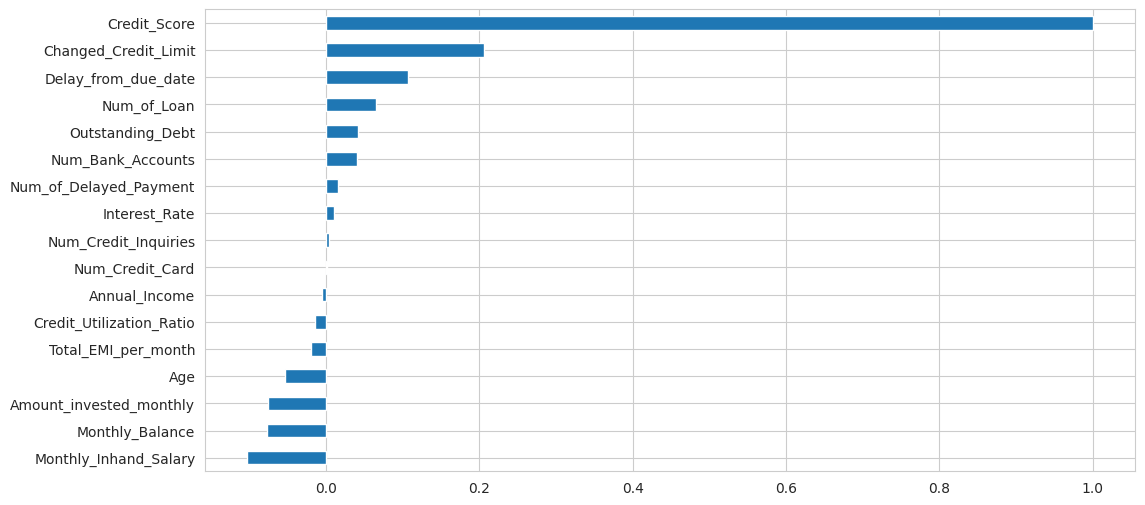

In [28]:
# Correlation of target variable with features after numerical transformation


numerical_df = df.select_dtypes(include=[np.number])
correlation_series = numerical_df.corr()['Credit_Score'][:-1].sort_values()
correlation_series.plot.barh();

In [29]:
# Encoding for categorical columns
# select columns of type 'object'
df.select_dtypes(include=['object']).columns


Index(['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount',
       'Payment_Behaviour'],
      dtype='object')

In [30]:
payment_behaviour_categories = ['Low_spent_Small_value_payments',
                                'Low_spent_Medium_value_payments',
                                'Low_spent_Large_value_payments',
                                'High_spent_Small_value_payments',
                                'High_spent_Medium_value_payments',
                                'High_spent_Large_value_payments']

payment_behaviour_encoder = OrdinalEncoder(categories=[payment_behaviour_categories])

df['Payment_Behaviour'] = payment_behaviour_encoder.fit_transform(df[['Payment_Behaviour']])

In [31]:
label_encoder = OrdinalEncoder()
df['Credit_Mix'] = label_encoder.fit_transform(df[['Credit_Mix']])

In [32]:
label_encoder = LabelEncoder()
df['Payment_of_Min_Amount'] = label_encoder.fit_transform(df['Payment_of_Min_Amount'])

In [33]:
label_encoder = LabelEncoder()
df['Occupation'] = label_encoder.fit_transform(df['Occupation'])

In [34]:
df.shape

(35233, 22)

In [35]:
df.head().T

,0,1,2,3,4
Age,23.000,23.000,5.000,23.000,23.000
Occupation,12.000,12.000,12.000,12.000,12.000
Annual_Income,19114.120,19114.120,19114.120,19114.120,19114.120
Monthly_Inhand_Salary,1824.843,1824.843,1824.843,1824.843,1824.843
Num_Bank_Accounts,3.000,3.000,3.000,3.000,3.000
Num_Credit_Card,4.000,4.000,4.000,4.000,4.000
Interest_Rate,3.000,3.000,3.000,3.000,3.000
Num_of_Loan,4.000,4.000,4.000,4.000,4.000
Delay_from_due_date,3.000,-1.000,3.000,5.000,6.000
Num_of_Delayed_Payment,7.000,0.000,7.000,4.000,0.000


In [36]:
# Separate properties and target variable

X = df.drop("Credit_Score", axis=1)
y = df.Credit_Score

In [37]:
y.value_counts(normalize=True)

Credit_Score
2   0.530
1   0.292
0   0.178
Name: proportion, dtype: float64

In [38]:
from imblearn.over_sampling import SMOTE

# Synthetic Minority Oversampling Technique

smote = SMOTE()
X, y = smote.fit_resample(X,y)

In [39]:
y.value_counts()

Credit_Score
0    18673
2    18673
1    18673
Name: count, dtype: int64

In [40]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    stratify=y, shuffle=True, random_state=42)

In [41]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (47616, 21) (47616,)
Testing set shape: (8403, 21) (8403,)


In [42]:
df["Credit_Score"].value_counts()

Credit_Score
2    18673
1    10290
0     6270
Name: count, dtype: int64

In [43]:
# Normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred_probabilities = model.predict(X_train)
    y_train_pred = y_train_pred_probabilities.argmax(axis=1)
    y_pred_probabilities = model.predict(X_test)
    y_pred = y_pred_probabilities.argmax(axis=1)

    print("Test Set:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    print("\nTrain Set:")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [52]:
# ANN Model
model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer = Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=120,
                               restore_best_weights=True)

model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test, y_test),
          validation_split=0.1,
          batch_size=512,
          epochs=900,
          verbose=1,
          callbacks=[early_stopping])

Epoch 1/900
93/93 [==============================] - 8s 51ms/step - loss: 0.8324 - accuracy: 0.6471 - val_loss: 0.7411 - val_accuracy: 0.7068
Epoch 2/900
93/93 [==============================] - 5s 50ms/step - loss: 0.7398 - accuracy: 0.7091 - val_loss: 0.7141 - val_accuracy: 0.7150
Epoch 3/900
93/93 [==============================] - 2s 25ms/step - loss: 0.7219 - accuracy: 0.7155 - val_loss: 0.7051 - val_accuracy: 0.7215
Epoch 4/900
93/93 [==============================] - 2s 26ms/step - loss: 0.7114 - accuracy: 0.7193 - val_loss: 0.6972 - val_accuracy: 0.7231
Epoch 5/900
93/93 [==============================] - 2s 25ms/step - loss: 0.7042 - accuracy: 0.7210 - val_loss: 0.6910 - val_accuracy: 0.7243
Epoch 6/900
93/93 [==============================] - 2s 25ms/step - loss: 0.6995 - accuracy: 0.7218 - val_loss: 0.6885 - val_accuracy: 0.7247
Epoch 7/900
93/93 [==============================] - 4s 38ms/step - loss: 0.6951 - accuracy: 0.7244 - val_loss: 0.6907 - val_accuracy: 0.7225
Epoch 

In [53]:
model.evaluate(X_train, y_train)

1488/1488 [==============================] - 3s 2ms/step - loss: 0.1556 - accuracy: 0.9454


[0.15557649731636047, 0.9454175233840942]

In [54]:
eval_metric(model, X_train, y_train, X_test, y_test)

263/263 [==============================] - 1s 2ms/step
Test Set:
[[2658   10  133]
 [  60 2511  230]
 [ 366  419 2016]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2801
           1       0.85      0.90      0.87      2801
           2       0.85      0.72      0.78      2801

    accuracy                           0.86      8403
   macro avg       0.85      0.86      0.85      8403
weighted avg       0.85      0.86      0.85      8403


Train Set:
[[15778     1    93]
 [   28 15569   275]
 [  829  1373 13670]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     15872
           1       0.92      0.98      0.95     15872
           2       0.97      0.86      0.91     15872

    accuracy                           0.95     47616
   macro avg       0.95      0.95      0.94     47616
weighted avg       0.95      0.95      0.94     47616



In [55]:
model.save('scoring_model.h5')